Import Python Libraries

In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
import scipy.io as sio
import xarray as xr
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

### Prepare Data

Read the data.

In [2]:
filename_pattern  = '/home/voyager-sbarc/arc/sst/hadisst/HadISST_sst.nc'
ds = xr.open_dataset(filename_pattern)
ds

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, nv: 2, time: 1787)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2018-11-16T12:00:00
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    14/1/2019 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

Crop the data to 30S-30N.

In [3]:
ds_subset = ds.sel(latitude=slice(30,-30), time=slice('1900-01-16', '2017-12-16'))
ds_subset

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, nv: 2, time: 1416)
Coordinates:
  * time       (time) datetime64[ns] 1900-01-16T12:00:00 ... 2017-12-16T12:00:00
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    14/1/2019 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

Compute the annual cycle of SST fitting the first and second harmonics.

In [4]:
climatology = ds_subset.groupby('time.month').mean('time')
climatology

/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, month: 12, nv: 2)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    time_bnds  (month, nv) float32 32323.508 32354.508 ... 32657.754 32688.754
    sst        (month, latitude, longitude) float32 19.350561 ... 22.045519

Create 1st two harmonics and add together

In [5]:
def fourier(ds,p):
    time = ds.month
    n = len(time) 
 
    ds,time = xr.broadcast(ds,time)

    f = 2.*np.pi*p/n
    ft = f*time

    sum_a = ds*np.cos(ft - 1.)
    sum_b = ds*np.sin(ft - 1.)
    coef_a = (2./n)*sum_a.sum('month',skipna=True)
    coef_b = (2./n)*sum_b.sum('month',skipna=True)

    return ft,coef_a, coef_b

def harmonic(ds):
    a0 = ds.mean('month',skipna=True)

    #-First Harmonic
    p     = 1
    ft,coef_a,coef_b = fourier(ds,p)
    harm1 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-Second Harmonic
    p     = 2
    ft,coef_a,coef_b = fourier(ds,p)
    harm2 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-First plus second
    combo = harm1 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    return combo

In [6]:
annual_cycle = harmonic(climatology)
annual_cycle

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, month: 12, nv: 2)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 29.5 28.5 27.5 26.5 ... -27.5 -28.5 -29.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    time_bnds  (nv, latitude, longitude, month) float64 3.243e+04 ... 3.258e+04
    sst        (latitude, longitude, nv, month) float64 19.4 18.41 ... 22.04

Remove the annual cycle from the monthly SST in each gridpoint

In [7]:
anomalies = ds_subset.groupby('time.month') - annual_cycle
anomalies.sst.shape
sst = anomalies.sst[:, :, :, 0]

Weight the SST anomaly value in each gridpoint by the square root of the cosine of the latitude

In [8]:
# Weight the data set according to weighting argument.
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)
wgts = xr.DataArray(wgts, coords=[sst.latitude], dims=['latitude'])
sst,weights = xr.broadcast(sst,wgts)
weighted_data = sst * weights
print(weighted_data.shape)

(1416, 60, 360)


### EOF Analysis

#### 1a. The SST data consist of 1787 points in time by 21600 points in space.

In [9]:
[numtimes, numlats, numlons] = weighted_data.shape

## flatten lat and lon into 1 spatial location identifier
X = np.reshape(weighted_data.values, [numtimes, numlons*numlats])
print(X.shape)



(1416, 21600)


In [10]:
# # center the data - need to do this to line up the missing data
# x1mean = np.mean(X, axis = 0)
# X = (X - x1mean)

## put the data into 2D dataarray and drop nans
locs = np.arange(numlats*numlons)
times = anomalies.time
foo = xr.DataArray(X, coords=[times, locs], dims=['time', 'space'])
foo

foo2 = foo.dropna(dim='space', how='any')
foo2

<xarray.DataArray (time: 1416, space: 16378)>
array([[-0.60712045, -0.62303804, -0.65393967, ..., -0.52581901,
        -0.52855406, -0.5052641 ],
       [-0.433982  , -0.43885202, -0.46641918, ..., -0.5651247 ,
        -0.57522867, -0.59948016],
       [ 0.03549078,  0.01177531, -0.02980639, ..., -0.54724354,
        -0.57779739, -0.54351096],
       ...,
       [ 0.66704441,  0.61098967,  0.56767186, ...,  0.45336911,
         0.40685934,  0.29709832],
       [ 0.56750411,  0.58509414,  0.55329708, ...,  0.36492852,
         0.23796268,  0.13340341],
       [ 0.76609776,  0.82149902,  0.8510893 , ...,  0.4540638 ,
         0.28908694,  0.17116572]])
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2017-12-16T12:00:00
  * space    (space) int64 0 1 2 3 4 5 6 ... 21594 21595 21596 21597 21598 21599

In [11]:
# ## For s-mode do not transpose [time x space]
# Xs = foo2.values
# print(X.shape)
# X_nomiss = X

## For t-mode transpose X so it is [space x time]
Xs = foo2.values.T
print(Xs.shape)
X_nomiss = np.transpose(X)


(16378, 1416)


In [12]:
# standardize by the column (variable) for missing data
x1mean = np.mean(Xs, axis = 0)
x1std = np.std(Xs, axis = 0)
X1s = (Xs - x1mean) / x1std
# X1s = (Xs - x1mean)

# standardize by the column (variable) for array without missing data removed
x1mean_reg = np.nanmean(X_nomiss, axis = 0)
# x1std_reg = np.nanstd(X_nomiss, axis = 0)
# X1s_reg = (X_nomiss - x1mean_reg) / x1std_reg
X1s_reg = (X_nomiss - x1mean_reg)


In [13]:
Z = X1s
# Check that column means=0 and std dev=1
test = np.mean(np.mean(Z, axis=0))
print("Column means: ", np.round(test,2))
test = np.mean(np.std(Z, axis=0))
print("Column std: ", np.round(test,2))

Column means:  -0.0
Column std:  0.42


#### 1b.	Compute the covariance matrix of SST anomalies using the time dimension

In [14]:
nspace = len(foo2.space)

# ## Compute Correlation Matrix for s-mode [time x space] * [space x time]
# A = (np.dot(Z, np.transpose(Z)))/(nspace - 1.)
# A.shape

## Compute Correlation Matrix for t-mode [time x space] * [space x time]
A = (np.dot(np.transpose(Z), Z))/(nspace - 1.)
A.shape

(1416, 1416)

Text(0.5, 1.0, 'Correlation Matrix')

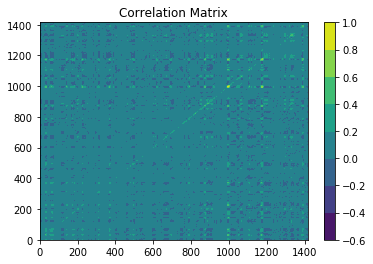

In [15]:
plt.contourf(A)
plt.colorbar()
plt.title('Correlation Matrix')

#### 1c. Compute the eigenvalues and eigenvectors of the covariance matrix.

In [16]:
## Compute the eigenvalues
eig, v = np.linalg.eig(A)
print(eig.shape)
print(v.shape)

(1416,)
(1416, 1416)


#### 1d. Plot the percentage of explained variance for eigenvalues 1-20.

Text(0, 0.5, 'Variance Explained (%)')

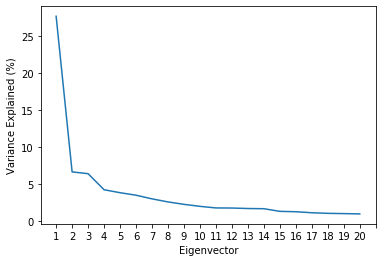

In [17]:
var_eig = eig/sum(eig)*100;
var_eig[:20]
plt.plot(var_eig[:20])
plt.xticks(np.arange(0,21,1), labels=np.arange(1,21,1))
plt.xlabel('Eigenvector')
plt.ylabel('Variance Explained (%)')

#### 1e. Plot the EOF patterns and PCs for the first 5 modes. 

In [18]:
## the shape of data before missings removed
print(X1s_reg.shape)

neofs = 4
evecs = v

# # s-mode project time EOF onto anomaly data (without missing data)
# tmp = np.matmul(evecs[:, 0:neofs].T, X1s_reg)
# pcs = tmp
# print(pcs.shape)

# t-mode project time EOF onto anomaly data that is centered and standardized (without missing data removed)
tmp = np.matmul(X1s_reg, evecs[:,0:neofs])
pcs = tmp.T
print(pcs.shape)

(21600, 1416)
(4, 21600)


In [19]:
EOF_reshape = np.reshape(pcs, [neofs, numlats, numlons])
print(EOF_reshape.shape)

(4, 60, 360)


EOF_ENSO_test.png


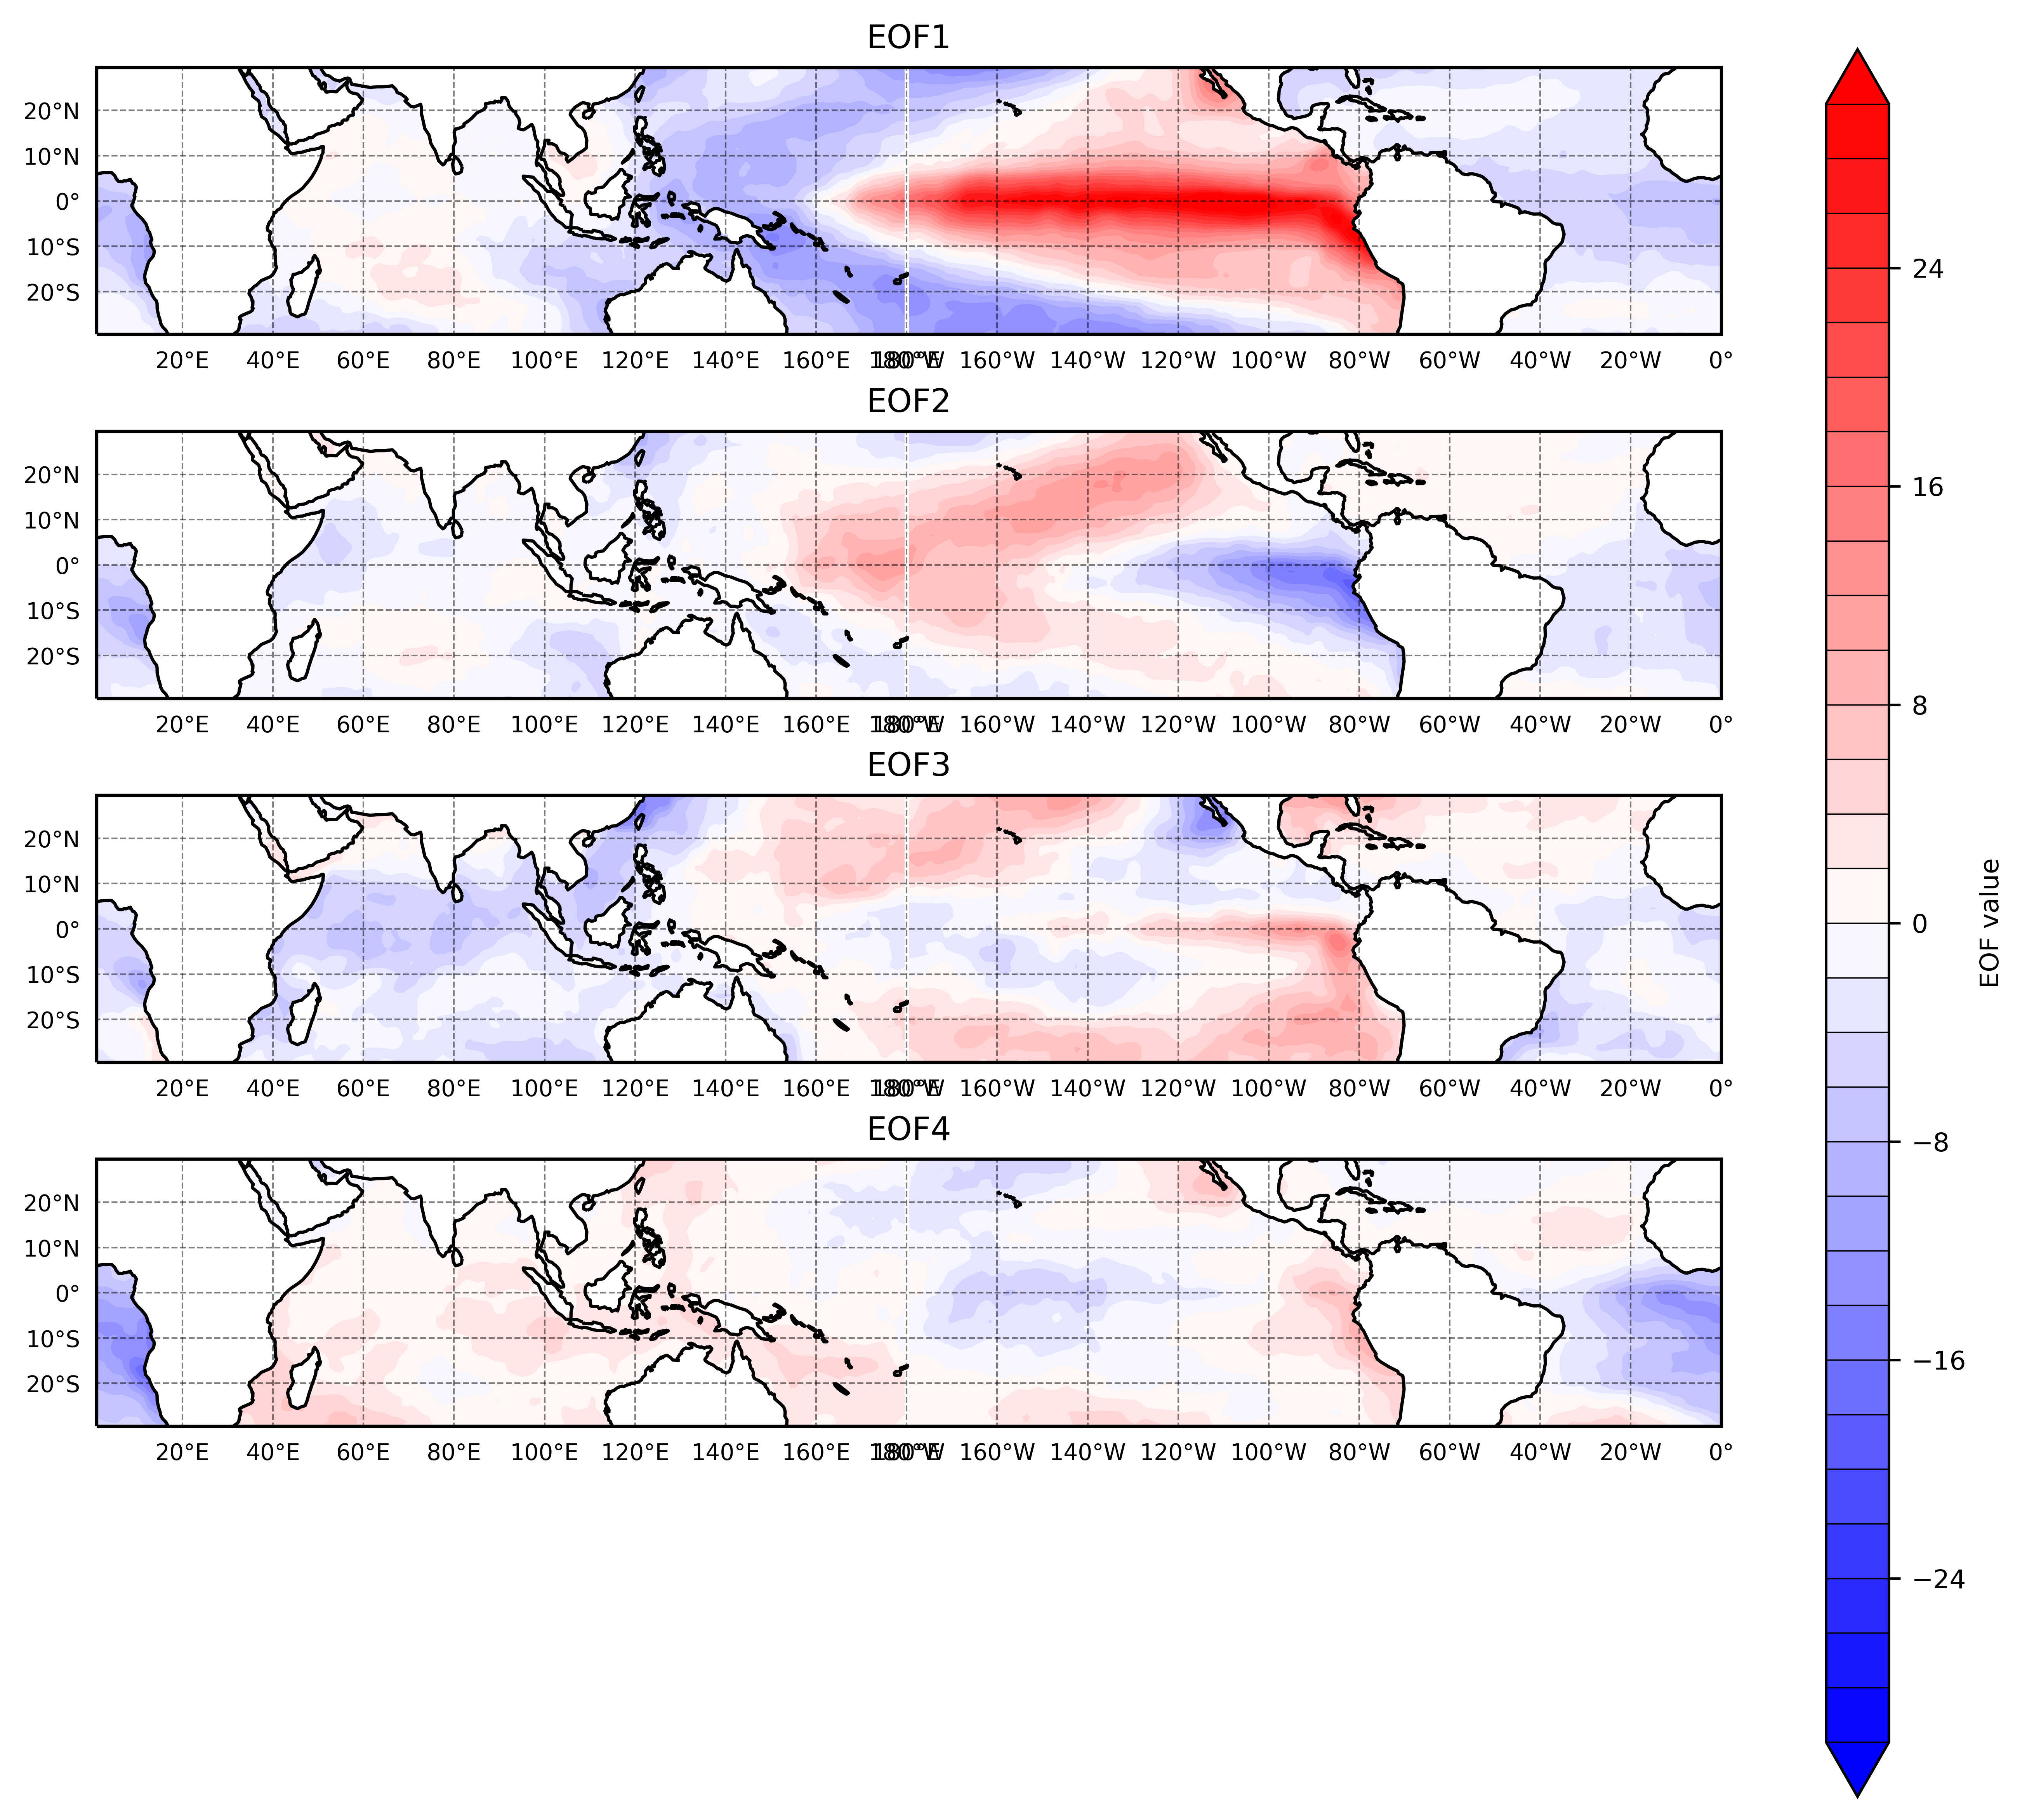

<Figure size 5400x6000 with 0 Axes>

In [20]:
fig = plt.figure(figsize=(9,10))
fig.dpi = 600
fname = 'EOF_ENSO_test'
fmt = 'png'
results = EOF_reshape
subtitles = ['EOF1', 'EOF2', 'EOF3', 'EOF4']

lats = sst['latitude']
lons = sst['longitude']

# clevs = np.arange(-0.025, 0.030, 0.005)
clevs = np.arange(-30, 31, 2)

for i in np.arange(len(results)):
    ax = plt.subplot(5, 1, i+1, projection=ccrs.PlateCarree(central_longitude=-179.5))
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree(central_longitude=-179.5))
    cf = ax.contourf(lons, lats, results[i], transform=ccrs.PlateCarree(),
                     extend='both', cmap='bwr', levels=clevs)
    ax.coastlines(linewidths=1.0)
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(-30, 40, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.95, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('EOF value', fontsize=8)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

PCA_ENSO_test.png


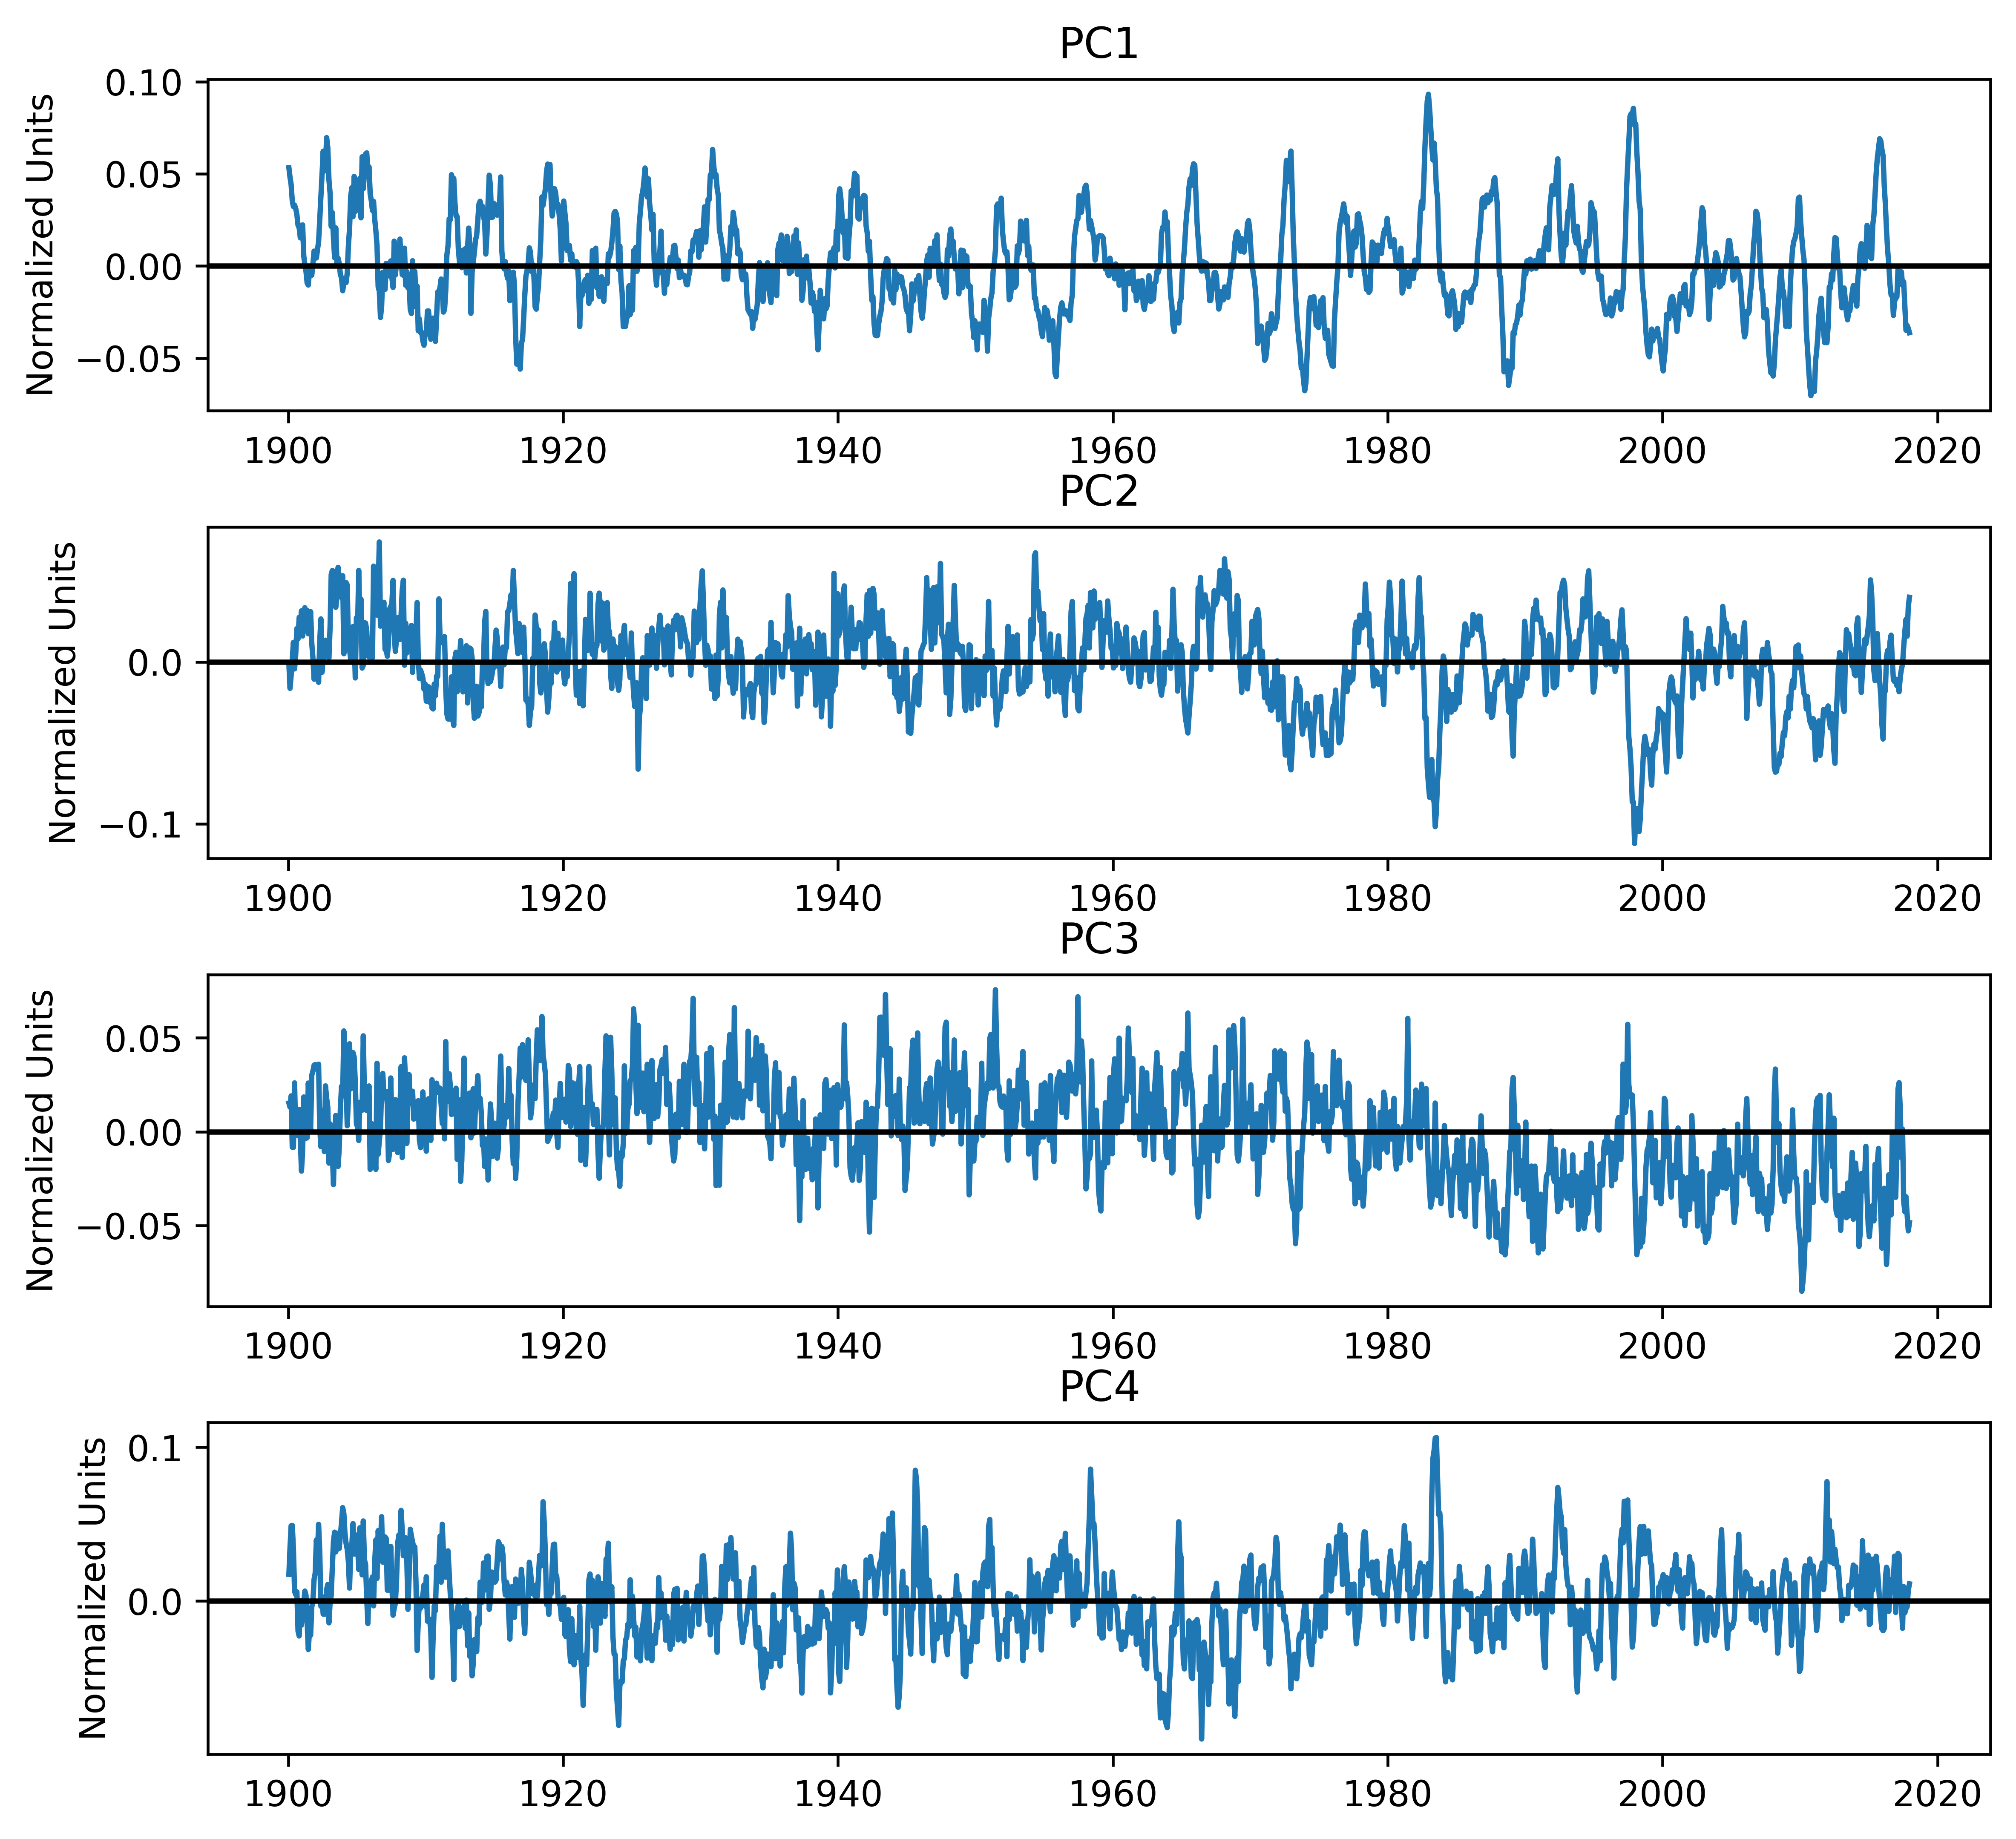

<Figure size 5400x6600 with 0 Axes>

In [21]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 600
fname = 'PCA_ENSO_test'
fmt = 'png'
results = v[:,:4]
subtitles = ['PC1', 'PC2', 'PC3', 'PC4']

X, nplots = results.shape

for i in np.arange(nplots):
    ax = plt.subplot(5, 1, i+1)
    ax.plot_date(sst.time.values, results[:,i], '-')
    ax.axhline(0, color='k')
#     ax.set_ylim(-3, 3)
    ax.set_ylabel('Normalized Units')
    ax.set_title(subtitles[i], fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### EOF Separation

#### 2a. Using SST anomalies, compute the first auto-correlation for each gridpoint and obtain an average value. Estimate the effective sample size using:

$$ n' \equiv \frac{1 - \rho_{1}}{1 + \rho_{1}}$$

In [ ]:
numtimes, numlats, numlons = weighted_data.shape
X1 = np.reshape(weighted_data[:-1, :,:].values, [numtimes-1, numlats*numlons])
X2 = np.reshape(weighted_data[1:, :,:].values, [numtimes-1, numlats*numlons])
X1.shape

autocorr1 = []
for i in np.arange(numlats*numlons):
    autocorr1.append(np.corrcoef(X1[:,i], X2[:,i]))

In [ ]:
autocorr1_array = np.array(autocorr1)
autocorr1_mean = np.nanmean(autocorr1_array[:, 1, 0])

sample_size = numtimes*((1-autocorr1_mean)/(1+autocorr1_mean))
print(sample_size)

#### 2b. Use the North et al (1982) criteria to estimate the uncertainty in the eigenvalues estimation.

In [ ]:
factor = np.sqrt(2.0 / sample_size)
errors = eig[:20] * factor
errors

#### 2c. Plot eigenvalues 1-20 with the error bars calculated in item 2b above.

In [ ]:
eig[:20]

In [ ]:
plt.errorbar(x=np.arange(0,20,1), y=eig[:20], yerr=errors, fmt='o', capsize=5)
f = plt.xticks(np.arange(0,21,1), labels=np.arange(1,21,1))

 ### Questions

**1.	Why do you need to weight the SST values by the square of cosine of latitude?**

The data is in a regular latitude/longitude grid, and needs to be transformed into an equal-area grid. To accomplish this, each grid cell needs ot be weighted (i.e. multiply the time series at each grid box by the square root of the
cosine of latitude). This weighting function compensates for the decrease of the gridcell size in the higher latitude regions. If the gridcells are not area-weighted, it is possible that the EOFs can shift spatially, yielding different results. 

**2.	How many EOF modes are separated?**

The first three EOFs seem well separated from the rest of the EOFs, particularly when looking at the first 20 eigenvalues. 

**3.	Please give an interpretation for EOFs 1-5.**

EOF 1 is showing a consistent positive loading across the spatial area. It is possible that it is not showing much of a spatial pattern because it is reflecting the overall warming trend of SST, which was not removed from the dataset. The first PC is showing a positive trend, particularly after 1960. EOF 2 is showing a loading pattern similar to that of ENSO, with a elongated zone of positive loading in the equatorial Pacific and strong, negative loading in all other ocean basins. The second PC is showing almost an opposite trend of the first PC, with decreasing values post-1960. The third EOF is showing another familiar ENSO pattern, with positive loading in the east equatorial pacific, and a sideways v shaped negative loading around the zone of positive loading in the Pacific. PC 3 is showing a pattern of decreasing values for about 20 years, then a sharp incline, particularly after 1960. EOF 4 has two areas of strong negative loading - one in the northern Pacific, and one in the southeast Atlantic. The fifth EOF has positive loading patterns near the west coast of South America, as well as in the central Atlantic. South Atlantic is showing a region of strong negative loading, similar to that of EOF4.  
